# Importing all the necessary libraries

In [1]:
import cv2
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Rescaling
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

# Loading the Dataset

In [3]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "Multiclass_Data",
    shuffle=True,
    image_size=(224,224),
    batch_size=32)

Found 8846 files belonging to 8 classes.


In [4]:
class_names = data.class_names
class_names

['ewaste',
 'food_waste',
 'leaf_waste',
 'metal_cans',
 'paper_waste',
 'plastic_bags',
 'plastic_bottles',
 'wood_waste']

# Displaying sample images 

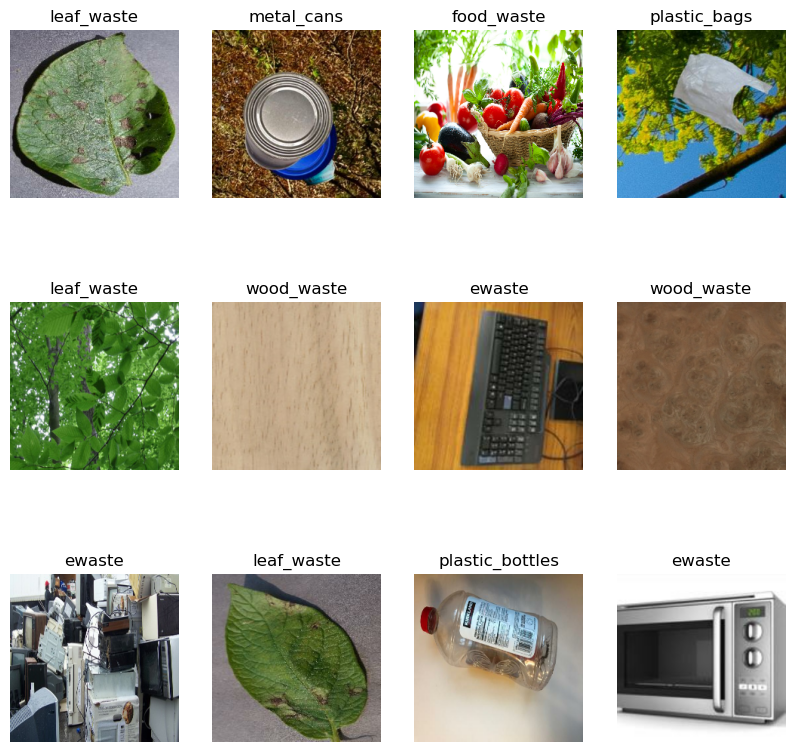

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Splitting the Dataset into training, testing and validation splits

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(data)

# Caching and shuffling the Datasets

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Data Preprocessing

## Rescaling:

In [8]:
rescale = tf.keras.Sequential([
    layers.Rescaling(1.0 / 255) 
])

## Data Augmentation:

In [9]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
  layers.RandomZoom(height_factor=0.3, width_factor=0.3)
])

### Mapping the augmentation to the training dataset:

In [10]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Building and Training

## Model Architecture:

In [11]:
model = models.Sequential([
    rescale,
    layers.Conv2D(64, kernel_size = (3,3), activation='relu',padding = 'same', input_shape=(32,224,224,3)),

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128,  kernel_size = (3,3), activation='relu',padding = 'same'),

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256,  kernel_size = (3,3), activation='relu',padding = 'same'),

    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(512,  kernel_size = (3,3), activation='relu',padding = 'same'),

    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),    
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.03)),
    layers.Dropout(0.25),
    
    layers.Dense(8, activation='softmax'),
])

model.build(input_shape=(32,224,224,3))

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 224, 224, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 224, 224, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (32, 112, 112, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 112, 112, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 56, 56, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 56, 56, 256)        

## Implemeting EarlyStopping:

In [13]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

## Compiling the model:

In [14]:
initial_learning_rate = 0.00001
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)

In [15]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Traiing the model
history = model.fit(train_ds, epochs=150, batch_size=32, verbose=1, validation_data=val_ds)

Epoch 1/150
220/220 [==============================] - 1114s 5s/step - loss: 23.2677 - accuracy: 0.3109 - val_loss: 15.8633 - val_accuracy: 0.5301
Epoch 2/150
220/220 [==============================] - 1085s 5s/step - loss: 11.8470 - accuracy: 0.5202 - val_loss: 8.6796 - val_accuracy: 0.5521
Epoch 3/150
220/220 [==============================] - 1071s 5s/step - loss: 6.8711 - accuracy: 0.5625 - val_loss: 5.3712 - val_accuracy: 0.5613
Epoch 4/150
220/220 [==============================] - 1047s 5s/step - loss: 4.4821 - accuracy: 0.5816 - val_loss: 3.6886 - val_accuracy: 0.5961
Epoch 5/150
220/220 [==============================] - 1036s 5s/step - loss: 3.2580 - accuracy: 0.5953 - val_loss: 2.7990 - val_accuracy: 0.6146
Epoch 6/150
220/220 [==============================] - 1048s 5s/step - loss: 2.5803 - accuracy: 0.6039 - val_loss: 2.3296 - val_accuracy: 0.6134
Epoch 7/150
220/220 [==============================] - 1079s 5s/step - loss: 2.1618 - accuracy: 0.6169 - val_loss: 2.0134 - val

## Plotting the Accuracy and Loss Curves

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='loss')
plt.plot(history.history['val_accuracy'], color='orange', label='val_loss')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Saving the model

In [ ]:
model.save('multiclass_model.h5')